In [2]:
import numpy as np
import serpentTools as st
from snapReactors.reactor_models.AutomatedSerpentModels.GCU.c3_radial_sens_2d.utilitities import*
import os
from numpy.linalg import norm
import matplotlib.image as mpimg

In [45]:
ringresFile = '/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/test_divref/s83d_ac_c3_gcu_ringxs_ringres_lay20_1.main_res.m'
ringres = st.read(ringresFile, reader='results')

SERPENT Serpent 2.2.1 found in /Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/test_divref/s83d_ac_c3_gcu_ringxs_ringres_lay20_1.main_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.


### System Analysis

In [46]:
# coreUni = ringres.universes['100', 0, 0, 0]
rootUni = ringres.universes['0', 0, 0, 0]

In [47]:
# rootUni.infExp.keys()

In [48]:
# ax = rootUni.plot('infTot', labels=['infAbs - system'])
# ax.grid()
# coreUni.plot('infTot', ax=ax, labels = ['infAbs - core'], legend='right')

In [49]:
def condense(universe, key, useInvFlux = False):
    cond = None
    if useInvFlux:
        invFlux = np.zeros(len(universe.infExp[key]))
        for i in range(0, len(invFlux)):
            invFlux[i] = 1/universe.infExp[key][i]
        cond = np.sum(np.multiply(universe.infExp[key], invFlux)/np.sum(invFlux))
    else:
        cond = np.sum(np.multiply(universe.infExp[key], universe.infExp['infFlx']))/np.sum(universe.infExp['infFlx'])
    return cond

In [50]:
fluxweight_coreTranspxs = condense(rootUni, 'infTranspxs')
invfluxweight_coreTranspxs = condense(rootUni, 'infTranspxs', useInvFlux=True)

fluxweight_coreDiff = 1/(3*fluxweight_coreTranspxs)
invfluxweight_coreDiff = 1/(3*invfluxweight_coreTranspxs)

print("fluxweighted infTranspxs : {:.3f}".format(fluxweight_coreTranspxs))
print("invfluxweighted infTranspxs : {:.3f}".format(invfluxweight_coreTranspxs))

print("fluxweighted infDiff : {:.3f}".format(fluxweight_coreDiff))
print("invfluxweighted infDiff : {:.3f}".format(invfluxweight_coreDiff))

coreAbs = condense(rootUni, 'infAbs')

fluxweight_coreDiffLen = np.sqrt(fluxweight_coreDiff/coreAbs)
invfluxweight_coreDiffLen = np.sqrt(invfluxweight_coreDiff/coreAbs)

print("fluxweighted infDiffLen : {:.3f}".format(fluxweight_coreDiffLen))
print("invfluxweighted infDiffLen : {:.3f}".format(invfluxweight_coreDiffLen))  

fluxweighted infTranspxs : 0.454
invfluxweighted infTranspxs : 0.334
fluxweighted infDiff : 0.735
invfluxweighted infDiff : 0.997
fluxweighted infDiffLen : 5.977
invfluxweighted infDiffLen : 6.962


### Radial GCU Resolution Study 2D

####  Make Sure Cases are unbiased torwards statistics on few-group data

In [51]:
maxs = []
max = None
maxunis = []
for uni in ringres.universes:
    maxs.append(np.max(ringres.universes[uni].infUnc['infTot']))
    maxunis.append(uni)
print(maxunis[np.where(maxs == np.max(maxs))[0][0] ], np.max(maxs))

UnivTuple(universe='101', burnup=0, step=0, days=0) 0.01843


#### Keff Comparison

In [52]:
reffKeff = ringres.resdata['absKeff']
print("Reference Serpent Keff: {:.5}, pcm: {}".format(reffKeff[0],reffKeff[1]*1e5))

Reference Serpent Keff: 0.98245, pcm: 5.7


In [53]:
ringResDF = postProcess('/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_ring_axial/nue_test_out.csv', isSteady=True)

In [54]:
def kToPCM(k):
    return 1e5*((k-1)/k)

In [55]:
griff_rkeff = ringResDF['eigenvalue'][1]

print("ring resolution keff: {:.5f}, pcmDiff: {:.1f}".format(griff_rkeff, kToPCM(griff_rkeff) - kToPCM(reffKeff[0])))

ring resolution keff: 0.98347, pcmDiff: 105.9


1. PCM difference decreases with increase in spatial resolution as espected

#### Verification of Few Group Spectrum

In [56]:
fgs_hr18 = [5.0000E-09, 2.5000E-08, 1.0000E-07, 4.0000E-07, 9.9600E-07, 3.0000E-06,
9.8770E-06, 2.7700E-05, 1.0000E-04, 5.5000E-04, 3.0000E-03, 1.5030E-02,
1.0000E-01, 4.0000E-01, 8.2100E-01, 1.3530E+00, 3.0000E+00, 6.0655E+00,
2.0000E+01]

In [57]:
# refFGSFile = '/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_radial_sens_2d/s82d_ac_c3_gcu_coreres.main_det0.m'
# refFGSDet = st.read(refFGSFile)
# refFGS = refFGSDet['fgs_spec']

In [58]:
def normZeroToOne(arr):
    normArr = np.zeros(len(arr))
    min = np.min(arr)
    max = np.max(arr)
    for i in range(0, len(arr)):
        normArr[i] = (arr[i] - min)/(max - min)
    return normArr

In [59]:
def normMaximum(arr):
    normArr = np.zeros(len(arr))
    max = np.max(arr)
    for i in range(0, len(arr)):
        normArr[i] = (arr[i])/(max)
        
    return normArr

In [60]:
# normRefFGS = normZeroToOne(refFGS.tallies)

In [61]:
# plt.stairs(normRefFGS)

In [62]:
# #collectFGS
# nFewGroups = 18
# griff_coreResFGS = []
# griff_ringResFGS = []
# griff_elemResFGS = []
# for i in range(nFewGroups-1, -1, -1):
#     griff_coreResFGS.append(coreResDF['Flux{}'.format(i+1)][1])
#     griff_ringResFGS.append(ringResDF['Flux{}'.format(i+1)][1])
#     griff_elemResFGS.append(elemResDF['Flux{}'.format(i+1)][1])

# normGriff_ringResFGS = normZeroToOne(griff_ringResFGS)
# normGriff_coreResFGS = normZeroToOne(griff_coreResFGS)
# normGriff_elemResFGS = normZeroToOne(griff_elemResFGS)

In [63]:
groupBins = np.linspace(0, 18, 19).astype("int")
print(groupBins)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [64]:
# plt.stairs(normGriff_coreResFGS, groupBins, label = "Griffin_Core", linewidth = 1, alpha = 1, linestyle = "-.")
# plt.stairs(normGriff_ringResFGS, groupBins, label = "Griffin_Ring", linewidth = 1, alpha = 1, linestyle = ":")
# plt.stairs(normGriff_elemResFGS, groupBins, label = "Griffin_Elem", linewidth = 1, alpha = 1, linestyle = "--")
# plt.stairs(normRefFGS, groupBins, label = "Serpent", color = "black", linewidth = 1, alpha = 0.5)
# plt.xticks(groupBins)
# plt.xlabel("Few-group Energy Bins")
# plt.ylabel("Normalized Few-Group Spectrum")
# plt.legend(loc='upper left')
# plt.tight_layout()
# plt.grid()

In [65]:
def calcL2NormDiffPerc(ref,  comp):
    diff = np.subtract(ref, comp)
    diffNorm  = norm(diff)
    base = norm(ref)
    return (diffNorm/base)*100

def calcPercentRelativeError(ref, comp):
    relErr = []
    diff = np.abs(np.subtract(ref, comp))

    for i in range(0, len(diff)):
        if (diff[i] !=0 ) & (ref[i] !=0) :
            #relErr.append(2*(diff[i]/(np.abs(ref[i])+np.abs(comp[i]))))
            relErr.append(100*diff[i]/ref[i])
        elif (diff[i] == 0):
            maxRef = np.max(ref)
            relErr.append(0)
        else:
            maxRef = np.max(ref)
            relErr.append(100*diff[i]/maxRef)
        #print("diff: {:.2f}, comp: {:.2f}, ref: {:.2f}, relerror: {:.2f}".format(diff[i], comp[i], ref[i], relErr[i]))

    return relErr

In [66]:
# coreL2NormDiffFGS = calcL2NormDiffPerc(normRefFGS, normGriff_coreResFGS)
# ringL2NormDiffFGS = calcL2NormDiffPerc(normRefFGS, normGriff_ringResFGS)
# elemL2NormDiffFGS = calcL2NormDiffPerc(normRefFGS, normGriff_elemResFGS)

In [67]:
# print("core resolution FGS l2normDiff (%): {:.3f}".format(coreL2NormDiffFGS))
# print("ring resolution FGS l2normDiff (%): {:.3f}".format(ringL2NormDiffFGS))
# print("elem resolution FGS l2normDiff (%): {:.3f}".format(elemL2NormDiffFGS))

#### Flux Map Comparison

In [68]:
ringRefMapFile = '/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/test_divref/s83d_ac_c3_gcu_ringxs_ringres_lay20.main_det0.m'
ringRefMapDet = st.read(ringRefMapFile, reader='det')

In [69]:
def griffinFluxMapReader(path):
    keys = ['volume', 'nufiss', 'power', 'absorption', 'scalar']
    block = []
    vol = []
    nufiss = []
    pow = []
    abs = []
    scalar = []
    with open(path, "r") as f:
        lines = f.readlines()
        f.close()

    bidx = None
    eidx = None
    hasBegun = False
    for ldx, line in enumerate(lines):
        if "Block average" in line:
            bidx = ldx+2
            hasBegun = True 
        if (line == "\n") & hasBegun:
            eidx = ldx
            break
    
    data = lines[bidx:eidx]

    dicts = []

    for i in range(0, len(data)):
        vals  = data[i].split()
        block.append(vals[0])
        vol.append(float(vals[1]))
        nufiss.append(float(vals[2]))
        pow.append(float(vals[3]))
        abs.append(float(vals[4]))
        scalar.append(float(vals[5]))

        dset = [vol[i], nufiss[i], pow[i], abs[i], scalar[i]]
        dicts.append(dict(zip(keys, dset)))


    map = dict(zip(block, dicts))
    return map

In [70]:
ringGriffBlockMap = griffinFluxMapReader('/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_ring_axial/nue_flux_map.txt')

In [71]:
ringGriffBlockMap

{'9': {'volume': 1550.566789,
  'nufiss': 0.0,
  'power': 0.0,
  'absorption': 4.214612e-09,
  'scalar': 0.0008376692},
 '101': {'volume': 22.593191,
  'nufiss': 2.312276e-05,
  'power': 3.07757e-16,
  'absorption': 1.390654e-05,
  'scalar': 0.0004794196},
 '102': {'volume': 22.593191,
  'nufiss': 4.48535e-05,
  'power': 5.972825e-16,
  'absorption': 2.685194e-05,
  'scalar': 0.0008190268},
 '103': {'volume': 22.593191,
  'nufiss': 6.328388e-05,
  'power': 8.427926e-16,
  'absorption': 3.784035e-05,
  'scalar': 0.001120579},
 '104': {'volume': 22.593191,
  'nufiss': 7.983186e-05,
  'power': 1.063207e-15,
  'absorption': 4.772265e-05,
  'scalar': 0.00139661},
 '105': {'volume': 22.593191,
  'nufiss': 9.421529e-05,
  'power': 1.254778e-15,
  'absorption': 5.628042e-05,
  'scalar': 0.001643336},
 '106': {'volume': 22.593191,
  'nufiss': 0.0001064433,
  'power': 1.417632e-15,
  'absorption': 6.362093e-05,
  'scalar': 0.001857103},
 '107': {'volume': 22.593191,
  'nufiss': 0.000116576,
  'p

In [72]:
def getBlock2UniMap(df, blockMap):
    uniMap = {}
    blocks = list(df['Block Name'])
    unis = list(df['material_id'])

    bkeyu = {}

    for bdx, block in enumerate(blocks):
        bkeyu[block.replace("block_", "")] = str(int(unis[bdx]))
        #print(unis[bdx])

    for block in blockMap:
        uniMap[bkeyu[block]] = blockMap[block]
    
    return uniMap, bkeyu

In [73]:
def getUni2BlockMap(df, uniMap):
    blockMap = {}

    blocks = list(df['Block Name'])
    unis = list(df['material_id'])

    ukeyb = {}

    for bdx, block in enumerate(blocks):
        ukeyb[str(int(unis[bdx]))] = block.replace("block_", "")

    for uni in uniMap:
        # uniMap[bkeyu[block]] = blockMap[block]

        blockMap[ukeyb[uni]] = uniMap[str(uni)]
    return blockMap, ukeyb

In [74]:
ringCellData = pd.read_csv('/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_ring_axial/s83d_ac_c3_gcu_ringxs_ringres_lay20_cellData.csv')


In [75]:
ringGriffMap, bkeyu = getBlock2UniMap(ringCellData, ringGriffBlockMap)

In [76]:
print(bkeyu)

{'9': '900', '101': '101', '102': '102', '103': '103', '104': '104', '105': '105', '106': '106', '107': '107', '108': '108', '109': '109', '110': '110', '111': '111', '112': '112', '113': '113', '114': '114', '115': '115', '116': '116', '117': '117', '118': '118', '119': '119', '120': '120', '201': '201', '202': '202', '203': '203', '204': '204', '205': '205', '206': '206', '207': '207', '208': '208', '209': '209', '210': '210', '211': '211', '212': '212', '213': '213', '214': '214', '215': '215', '216': '216', '217': '217', '218': '218', '219': '219', '220': '220', '301': '301', '302': '302', '303': '303', '304': '304', '305': '305', '306': '306', '307': '307', '308': '308', '309': '309', '310': '310', '311': '311', '312': '312', '313': '313', '314': '314', '315': '315', '316': '316', '317': '317', '318': '318', '319': '319', '320': '320', '401': '401', '402': '402', '403': '403', '404': '404', '405': '405', '406': '406', '407': '407', '408': '408', '409': '409', '410': '410', '411': 

In [77]:
# print(coreGriffMap)
# print(ringGriffMap)
# print(elemGriffMap)

In [78]:

ringUnis = list(ringGriffMap.keys())


# print(createDetectors(coreUnis))
# print(createDetectors(ringUnis))
# print(createDetectors(elemUnis))

In [79]:
def getUniValsList(map, attr):
    vals = []
    for uni in map:
        vals.append(map[uni][attr])
    return vals

In [80]:
coreNuFissMap = {}
coreCapMap = {}

coreNuFiss = []
coreCap = []

ringNuFissMap = {}
ringCapMap = {}

ringNuFiss = []
ringCap = []

elemNuFissMap = {}
elemCapMap = {}

elemNuFiss = []
elemCap = []



for uni in ringUnis:
    ringNuFissMap[uni] = ringRefMapDet["nuFissRate{}".format(uni)]
    ringCapMap[uni] = ringRefMapDet["scalarFlux{}".format(uni)]



In [81]:
for uni in ringNuFissMap:
    ringNuFiss.append(ringNuFissMap[uni].tallies/ringGriffMap[uni]['volume'])
    ringCap.append(ringCapMap[uni].tallies/ringGriffMap[uni]['volume'])

In [82]:

griffRingNuFiss = getUniValsList(ringGriffMap, 'nufiss')
griffRingScalar = getUniValsList(ringGriffMap, 'scalar')

In [83]:
ringNuFissMap

{'900': <serpentTools.detectors.Detector at 0x7f7b308d2250>,
 '101': <serpentTools.detectors.Detector at 0x7f7b33c7c250>,
 '102': <serpentTools.detectors.Detector at 0x7f7b33c7c280>,
 '103': <serpentTools.detectors.Detector at 0x7f7b33c7c2b0>,
 '104': <serpentTools.detectors.Detector at 0x7f7b33c7c2e0>,
 '105': <serpentTools.detectors.Detector at 0x7f7b33c7c310>,
 '106': <serpentTools.detectors.Detector at 0x7f7b33c7c340>,
 '107': <serpentTools.detectors.Detector at 0x7f7b33c7c370>,
 '108': <serpentTools.detectors.Detector at 0x7f7b33c7c3a0>,
 '109': <serpentTools.detectors.Detector at 0x7f7b33c7c3d0>,
 '110': <serpentTools.detectors.Detector at 0x7f7b33c7c400>,
 '111': <serpentTools.detectors.Detector at 0x7f7b33c7c430>,
 '112': <serpentTools.detectors.Detector at 0x7f7b33c7c460>,
 '113': <serpentTools.detectors.Detector at 0x7f7b33c7c490>,
 '114': <serpentTools.detectors.Detector at 0x7f7b33c7c4c0>,
 '115': <serpentTools.detectors.Detector at 0x7f7b33c7c4f0>,
 '116': <serpentTools.de

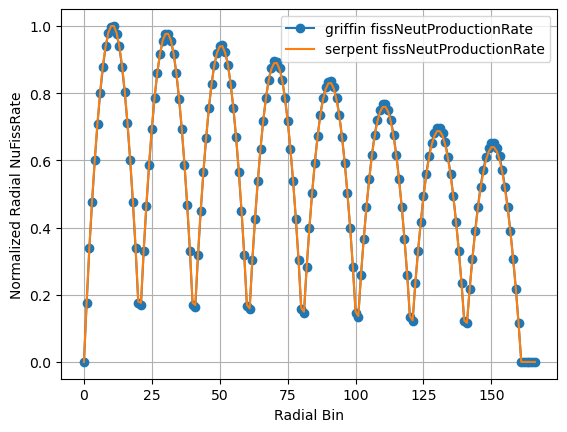

In [84]:
plt.plot(normMaximum(griffRingNuFiss), label = "griffin fissNeutProductionRate", marker = "o")
plt.plot(normMaximum(ringNuFiss), label = "serpent fissNeutProductionRate")
plt.ylabel("Normalized Radial NuFissRate")
plt.xlabel("Radial Bin")
plt.legend()
plt.grid()

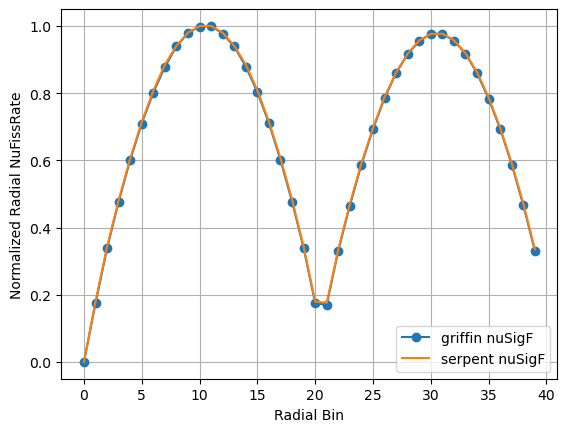

In [85]:
plt.plot(normMaximum(griffRingNuFiss[0:40]), label = "griffin nuSigF", marker = "o")
plt.plot(normMaximum(ringNuFiss[0:40]), label = "serpent nuSigF")
plt.ylabel("Normalized Radial NuFissRate")
plt.xlabel("Radial Bin")
plt.legend()
plt.grid()

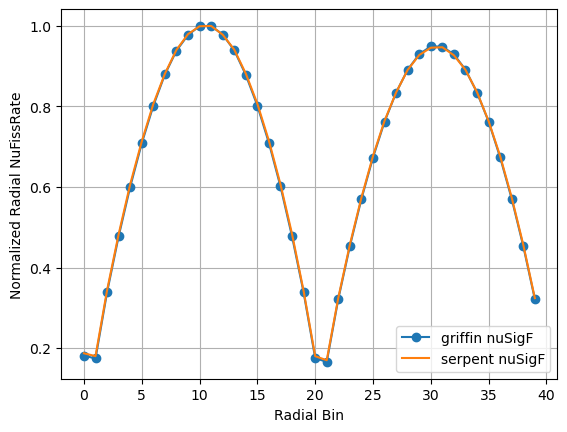

In [86]:
plt.plot(normMaximum(griffRingNuFiss[40:80]), label = "griffin nuSigF", marker = "o")
plt.plot(normMaximum(ringNuFiss[40:80]), label = "serpent nuSigF")
plt.ylabel("Normalized Radial NuFissRate")
plt.xlabel("Radial Bin")
plt.legend()
plt.grid()

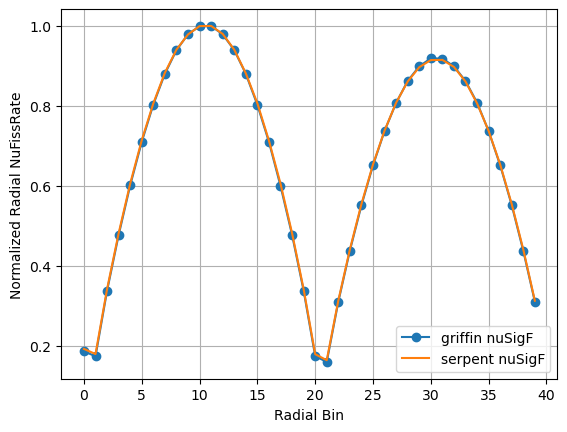

In [87]:
plt.plot(normMaximum(griffRingNuFiss[80:120]), label = "griffin nuSigF", marker = "o")
plt.plot(normMaximum(ringNuFiss[80:120]), label = "serpent nuSigF")
plt.ylabel("Normalized Radial NuFissRate")
plt.xlabel("Radial Bin")
plt.legend()
plt.grid()

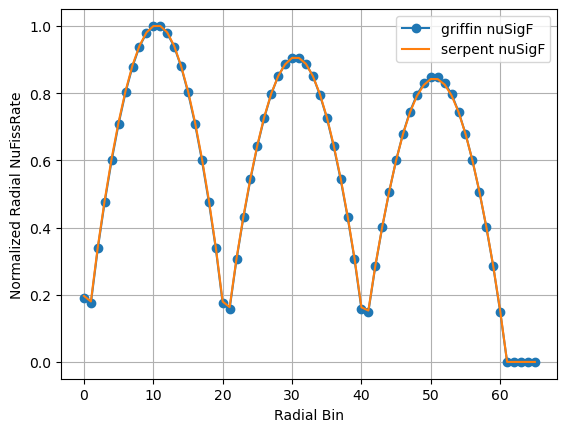

In [88]:
plt.plot(normMaximum(griffRingNuFiss[100:-1]), label = "griffin nuSigF", marker = "o")
plt.plot(normMaximum(ringNuFiss[100:-1]), label = "serpent nuSigF")
plt.ylabel("Normalized Radial NuFissRate")
plt.xlabel("Radial Bin")
plt.legend()
plt.grid()

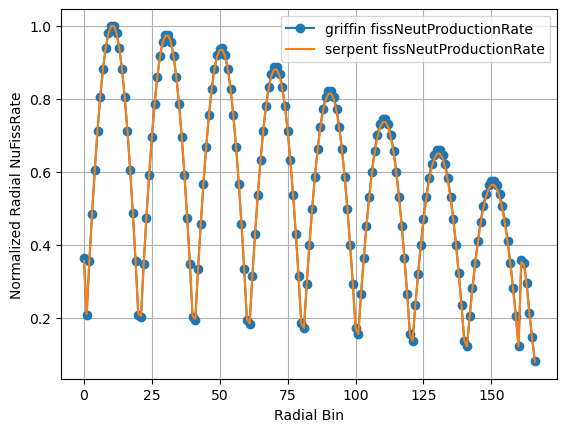

In [89]:
plt.plot(normMaximum(griffRingScalar), label = "griffin fissNeutProductionRate", marker = "o")
plt.plot(normMaximum(ringCap), label = "serpent fissNeutProductionRate")
plt.ylabel("Normalized Radial NuFissRate")
plt.xlabel("Radial Bin")
plt.legend()
plt.grid()

In [243]:
ringL2NormDiffNuFiss = calcL2NormDiffPerc(normMaximum(ringNuFiss), normMaximum(griffRingNuFiss))
print("ring resolution NuFissRate l2normDiff (%): {:.3f}".format(ringL2NormDiffNuFiss))

ring resolution NuFissRate l2normDiff (%): 3.814


In [244]:
ringL2NormDiffScalar = calcL2NormDiffPerc(normMaximum(ringCap), normMaximum(griffRingScalar))
print("ring resolution ScalarFlux l2normDiff (%): {:.3f}".format(ringL2NormDiffScalar))

ring resolution ScalarFlux l2normDiff (%): 3.680


In [245]:
ringNuFissRateRelError = calcPercentRelativeError(normMaximum(ringNuFiss), normMaximum(griffRingNuFiss))
ringNuFissRateRelErrorMap = dict(zip(ringUnis, ringNuFissRateRelError))

ringScalarRelError = calcPercentRelativeError(normMaximum(ringCap), normMaximum(griffRingScalar))
ringScalarRelErrorMap = dict(zip(ringUnis, ringScalarRelError))

In [246]:
serpNuFissMap = dict(zip(ringUnis, normMaximum(ringNuFiss)))
griffNuFissMap = dict(zip(ringUnis, normMaximum(griffRingNuFiss)))

serpScalarMap = dict(zip(ringUnis, normMaximum(ringCap)))
griffScalarMap = dict(zip(ringUnis, normMaximum(griffRingScalar)))

In [247]:
errorArr = np.ones(len(ringNuFissRateRelError))*5
highErrorsIdx = np.where(ringScalarRelError > errorArr)[0]

for idx, index in enumerate(highErrorsIdx):
    print(ringUnis[index], ringScalarRelError[index])


111 7.157343016717702
211 7.055264859109171
311 6.729717677267305
411 6.421080399527514
511 5.98023876844487
611 5.402865741462362
112 23.038488566375573
212 22.955692820104748
312 22.725677939553318
412 22.448350117704504
512 22.187551570489568
612 21.80148065109053
712 21.429786395587254
812 20.980711417893197


In [184]:
maxNuFissError = np.max(ringNuFissRateRelError)
maxScalarError = np.max(ringScalarRelError)

In [185]:
for uni in ringScalarRelErrorMap:
    if ringScalarRelErrorMap[uni] == maxScalarError:
        print(uni)


112


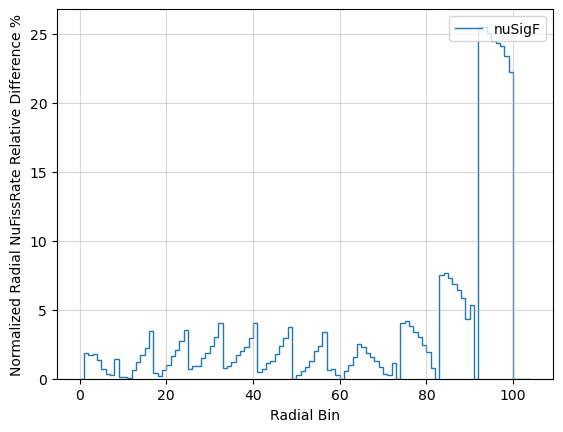

In [186]:
plt.stairs(ringNuFissRateRelError , label = "nuSigF", alpha = 1)
plt.ylabel("Normalized Radial NuFissRate Relative Difference %")
plt.xlabel("Radial Bin")
plt.legend()
plt.grid(alpha = 0.5)

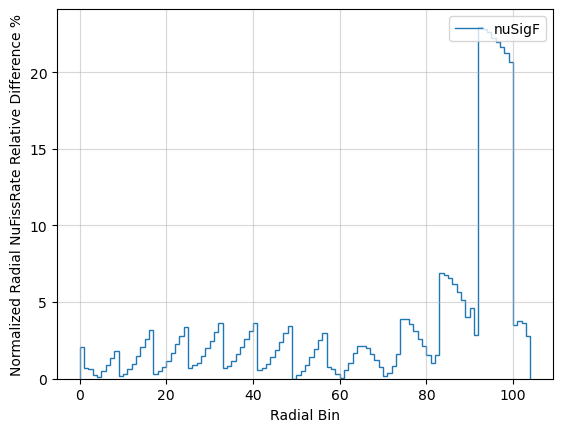

In [187]:
plt.stairs(ringScalarRelError , label = "nuSigF", alpha = 1)
plt.ylabel("Normalized Radial NuFissRate Relative Difference %")
plt.xlabel("Radial Bin")
plt.legend()
plt.grid(alpha = 0.5)

In [188]:
def createAppendCSV(cellData, keys, params, vals, exportPath, useBlockId = False):
    xyz = ['x', 'y', 'z']

    for param in params:
        xyz.append(param)

    appendDF = pd.DataFrame(columns=xyz)

    map = {}

    for key in keys:
        for pdx, param in enumerate(params):
            map[key] = {}
            
    for kdx, key in enumerate(keys):
        for pdx, param in enumerate(params):
            map[key][param] = vals[pdx][kdx]

    
    if not useBlockId:
        pointKeys = np.array(list(cellData['material_id'])).astype('int')
    else:
        pointKeys = []
        blocks = list(cellData['Block Name'])
        for i in range(0, len(blocks)):
            pointKeys.append(int(blocks[i].replace("block_", "")))

    appendDF['x'] = list(cellData['Points_0'])
    appendDF['y'] = list(cellData['Points_1'])
    appendDF['z'] = list(cellData['Points_2'])

    for param in params:
        pointData = []
        for i in range(0, len(pointKeys)):
            pointData.append(map[str(pointKeys[i])][param])
        
        appendDF[param] = pointData

    appendDF.to_csv(exportPath, index=False)
    
    return appendDF

In [189]:
def createAppendCSVNEW(keys, maps, path):
    keys.append("matid")  
    appendDF = pd.DataFrame(columns= keys)


    for kdx, key in enumerate(keys):
        temp = []
        for matId in maps[0]:
            if key == "matid":
                #print(matId)
                temp.append(matId)
            else:
                #print(maps[kdx][matId])
                temp.append(maps[kdx][matId])
        appendDF[key] = temp
            
    appendDF.to_csv(path, index=False)
    return appendDF

In [191]:
cellDataPath = '/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/s83d_griffin_cellDataAppend.csv'
keys = ['norm_RefnuFissRate', 'norm_griffnuFissRate', 'nuFissRateRelError', 'norm_RefscalarFlux', 'norm_griffscalarFlux', 'scalarFluxRelError']
maps = [serpNuFissMap, griffNuFissMap, ringNuFissRateRelErrorMap, serpScalarMap, griffScalarMap, ringScalarRelErrorMap]
createAppendCSVNEW(keys, maps, cellDataPath)

,norm_RefnuFissRate,norm_griffnuFissRate,nuFissRateRelError,norm_RefscalarFlux,norm_griffscalarFlux,scalarFluxRelError,matid
0,0.00000,0.00000,0.00000,0.35350,0.36071,2.03877,900
1,0.24331,0.23885,1.83563,0.27379,0.27194,0.67274,101
2,0.23800,0.23383,1.75125,0.26693,0.26526,0.62682,201
3,0.22893,0.22483,1.78748,0.25545,0.25487,0.23051,301
4,0.21634,0.21346,1.33237,0.24039,0.24064,0.10487,401
...,...,...,...,...,...,...,...
99,0.19763,0.15373,22.21264,0.19686,0.15619,20.65953,812
100,0.00000,0.00000,0.00000,0.20217,0.20924,3.49805,4000
101,0.00000,0.00000,0.00000,0.13795,0.14317,3.78069,4100
102,0.00000,0.00000,0.00000,0.07624,0.07901,3.63701,4200
